## Load and prepare data

In [1]:
import pickle
import limix
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
corr_dir = GTEx_directory + '/data/correction/'
sys.path.insert(0, GTEx_directory)
from src.utils.helpers import *
%matplotlib inline
import pandas
import glob
from scipy.stats import norm
import h5py
from tqdm import tqdm
import scipy



# 1. extract donors that have images
filelist = glob.glob(GTEx_directory + '/data/features/Lung/retrained*_256_l-1.hdf5')
donorlist = [x.split('/')[-1] for x in filelist]
donorlist = [x.split('_')[1] for x in donorlist]
donorlist = ['-'.join(x.split('-')[0:2]) for x in donorlist]

# 2. extract donors with sample attributes
sample_attributes = pandas.read_table(GTEx_directory + '/data/GTEx_download/GTEx_v7_Annotations_SampleAttributesDS.txt')
RNA_sample_confounders = ['SAMPID', 'SMRIN', 'SME2MPRT','SMCHMPRS','SMNTRART','SMNUMGPS','SMMAPRT','SMEXNCRT','SM550NRM','SMGNSDTC','SMUNMPRT','SM350NRM','SMRDLGTH','SMMNCPB','SME1MMRT','SMSFLGTH','SMESTLBS','SMMPPD','SMNTERRT','SMRRNANM','SMRDTTL','SMVQCFL','SMMNCV','SMTRSCPT','SMMPPDPR','SMCGLGTH','SMGAPPCT','SMUNPDRD','SMNTRNRT','SMMPUNRT','SMEXPEFF','SMMPPDUN','SME2MMRT','SME2ANTI','SMALTALG','SME2SNSE','SMMFLGTH','SMSPLTRD','SME1ANTI','SMBSMMRT','SME1SNSE','SME1PCTS','SMRRNART','SME1MPRT','SMNUM5CD','SMDPMPRT','SME2PCTS']
tissue_sample_confounders = ['SMATSSCR', 'SMCENTER', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SAMPID']
sample_prep_covariates = sample_attributes[sample_attributes['SMTSD'] == 'Lung'][tissue_sample_confounders].dropna()
SMCENTER_dummy = pd.get_dummies(sample_prep_covariates['SMCENTER'])
for d in SMCENTER_dummy.columns:
    sample_prep_covariates['SMCENTER_' + d] = SMCENTER_dummy[d]
sample_prep_covariates = sample_prep_covariates.drop('SMCENTER', axis=1)
# Take log of Ischemic time
sample_prep_covariates['SMTSISCH'] = np.log(sample_prep_covariates['SMTSISCH'])
# Take log of PAX time
sample_prep_covariates['SMTSPAX'] = np.log(sample_prep_covariates['SMTSPAX'])
sample_prep_covariates['SAMPID'] = ['-'.join(x.split('-')[0:2]) for x in list(sample_prep_covariates['SAMPID'])]
# Drop duplicate samples and take the one that has the highest RIN number
sample_prep_covariates = sample_prep_covariates.sort_values('SMRIN').drop_duplicates('SAMPID', keep='last')
sample_prep_covariates.index = sample_prep_covariates['SAMPID']
donors_with_sample_attributes = sample_prep_covariates['SAMPID']
sample_prep_covariates = sample_prep_covariates.drop('SAMPID', axis=1)
donors_with_sample_attributes = sample_prep_covariates.index.tolist()

# 3. extract donors with expression
expression_table = pandas.read_table(GTEx_directory + '/data/GTEx_download/GTEx_Analysis_v7_eQTL_expression_matrices/Lung.v7.normalized_expression.bed',sep='\t')
expression_table.index = expression_table['gene_id']
donors_with_expression = list(expression_table.columns[4:])

# 4. Extract raw TPM expression
# tpm_expression = pandas.read_table(GTEx_directory + '/data/GTEx_download/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct', sep='\t')
# headers = ['Name', 'Description'] + list(set(tpm_expression.columns).intersection(set(lung_samp_ids)))
# tpm_expression[headers].to_csv(GTEx_directory + '/data/GTEx_download/lung_tmp_expression.csv')
tpm_lung_expression = pd.read_csv(GTEx_directory + '/data/GTEx_download/lung_tmp_expression.csv')
tpm_lung_expression.columns = list(tpm_lung_expression.columns[0:3]) + ['-'.join(x.split('-')[0:2]) for x in tpm_lung_expression.columns[3:]]
tpm_lung_expression.index = tpm_lung_expression['Name']

# 5. find intersection: 291 samples
donor_intersection = list(set(donors_with_sample_attributes).intersection(set(donors_with_expression)).intersection(set(donorlist)))


# 6. Read in confounding matrix table used for the GTEx eQTL analysis. Includes genotype PCs and PEER factors
PEER_table = pandas.read_table(GTEx_directory + '/data/GTEx_download/GTEx_Analysis_v7_eQTL_covariates/Lung.v7.covariates.txt',sep='\t')
PEER_idx = np.array([x.startswith('InferredCov') for x in list(PEER_table['ID'])])
# 7. Extract the PEER factors for the donor intersection
PEER_factors = PEER_table[donor_intersection]
PEER_factors = PEER_factors.iloc[PEER_idx,:]
PEER_factors = PEER_factors.T
PEER_table.index = PEER_table['ID']
PEER_table = PEER_table.drop('ID', axis=1)

donor_confounders = PEER_table.loc[['C1', 'C2', 'C3','sex']]

# 8. build confounding and expression matrix for these donors
sample_confounders = sample_prep_covariates.loc[donor_intersection]

expression = expression_table[donor_intersection]
expression = expression.T
donor_confounders = donor_confounders[donor_intersection]
donor_confounders = donor_confounders.T
raw_variances = tpm_lung_expression[donor_intersection].loc[list(set(tpm_lung_expression.index).intersection(set(expression.columns)))].var(1)
largest_raw_variance = np.argsort(raw_variances)[-100:].index.tolist()


RNA_sample_covariates = sample_attributes[sample_attributes['SMTSD'] == 'Lung'][RNA_sample_confounders]
RNA_sample_covariates['SAMPID'] = ['-'.join(x.split('-')[0:2]) for x in list(RNA_sample_covariates['SAMPID'])]
RNA_sample_covariates.index = RNA_sample_covariates['SAMPID']
RNA_sample_covariates = RNA_sample_covariates.sort_values('SMRIN').drop_duplicates('SAMPID', keep='last')

# 9. Drop NaNs
#Drop any columns that are all NaN
RNA_sample_covariates = RNA_sample_covariates.loc[donor_intersection].dropna(how='all',axis=1)
#Drop any samples that have any NaNs
RNA_sample_covariates = RNA_sample_covariates.dropna(how='any',axis=0)
RNA_sample_covariates = RNA_sample_covariates.drop('SAMPID', axis=1)
RNA_sample_donors = RNA_sample_covariates.index.tolist()
RNA_sample_PEER = PEER_table[RNA_sample_donors].T.iloc[:,3:-(2+20)]

# RNA_sample_PEER = RNA_sample_PEER.T.as_matrix()

# 10. Filter to confounders with variance > 0
RNA_sample_covariates = RNA_sample_covariates[RNA_sample_covariates.columns[RNA_sample_covariates.var(0) > 0]]

confounders = pd.concat([donor_confounders.loc[RNA_sample_donors], sample_confounders.loc[RNA_sample_donors], RNA_sample_covariates.iloc[:,1:]],axis=1)

# 10. Extract image activations of donors
activations = []
pbar = tqdm(total=len(donor_intersection))
for d in donor_intersection:
    fn = glob.glob(GTEx_directory + '/data/features/Lung/retrained_{}*_256_l-1.hdf5'.format(d))[0]
    with h5py.File(fn) as f:
        features = f['features'].value
        agg_features = features.mean(0)
    activations.append(agg_features)
    pbar.update(1)
pbar.close()
activations = np.array(activations)

/hps/nobackup/research/stegle/users/willj/miniconda3/envs/HistoVAE/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Helper functions

In [2]:
def estimate_lambda(pv):
    """estimate lambda form a set of PV"""
    LOD2 = sp.median(st.chi2.isf(pv, 1))
    null_median = st.chi2.median(1)
    L = (LOD2 / null_median)
    return L

def quantile_normalize_to_gaussian(x):
    """ """
    n = len(x)
    rank_x = scipy.stats.rankdata(x)
    unif = (rank_x + 1) / (n + 2)
    g_x = norm.ppf(unif)
    return g_x

def regress_out_sample_confounders(data):
    choice_of_confounders = sample_confounders.as_matrix()
    lr = LinearRegression()
    lr.fit(choice_of_confounders, data)
    res_data = data - lr.predict(choice_of_confounders)
    return res_data

def regress_out_donor_confounders(data):    
    lr = LinearRegression()
    lr.fit(donor_confounders, data)
    res_data = data - lr.predict(donor_confounders)
    return res_data

def regress_out_k_noise_confounders(expression, k):
    print ('Regressing out {} noise confounders from expression'.format(k))
    random_covariates = np.random.random(size=(expression.shape[0],k))
    lr = LinearRegression()
    lr.fit(random_covariates, expression)
    expression_c = expression - lr.predict(random_covariates)
    return expression_c
    
def regress_out_k_peer_factors(expression, k):
    print ('Regressing out {} PEER factors from expression'.format(k))
    lr = LinearRegression()
    lr.fit(PEER_factors.iloc[:,:k].as_matrix(), expression)
    res_expression = expression - lr.predict(PEER_factors.iloc[:,:k].as_matrix())
    return res_expression

    
def gaussianize(data):
    print ('Gaussianizing')
    # gaussianize input data columnwise
    g_data = np.zeros_like(data)
    n_samples = g_data.shape[1]
    for i in range(n_samples):
        x = data[:,i].copy()
        g_x = quantile_normalize_to_gaussian(x)
        g_data[:,i] = g_x
    return g_data

# Function to perform pipeline.
parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': False,
            'peer_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
            
        },
        'activations': {
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
        }
}


def pipeline(activations, expression, parameters):

    activations_c = activations.copy()
    expression_c = expression.copy()
#     import pdb; pdb.set_trace()

    # Run parameters on expression
    if parameters['expression']['peer_correct']:
        k = parameters['expression']['peer_correct']
        expression_c = regress_out_k_peer_factors(expression_c, k)
    
    if parameters['expression']['noise_correct']:
        k = parameters['expression']['noise_correct']
        expression_c = regress_out_k_noise_confounders(expression_c, k)
        
    if parameters['expression']['donor_cov_correct']:
        k = parameters['expression']['donor_cov_correct']
        expression_c = regress_out_donor_confounders(expression_c)

    if parameters['expression']['sample_cov_correct']:
        k = parameters['expression']['sample_cov_correct']
        expression_c = regress_out_sample_confounders(expression_c)

    

    # Filter to the 100 most variable expression residuals. If nothing has been regressed out, use variance of raw TPMs
    if not (parameters['expression']['peer_correct'] or parameters['expression']['peer_correct'] or parameters['expression']['sample_cov_correct']):
        
        expression_c = expression_c[largest_raw_variance]
    else:
        sorted_idx = np.argsort(expression_c.var(0))[::-1]
        expression_c = expression_c.iloc[:,sorted_idx[0:100]].as_matrix()

    if parameters['expression']['gaussianize']:
        expression_c = gaussianize(expression_c)

    # Run parameters on activations
    if parameters['activations']['peer_correct']:
        k = parameters['activations']['peer_correct']
        activations_c = regress_out_k_peer_factors(activations_c, k)

    if parameters['activations']['sample_cov_correct']:
        k = parameters['activations']['sample_cov_correct']
        activations_c = regress_out_sample_confounders(activations_c)

    if parameters['activations']['donor_cov_correct']:
        k = parameters['activations']['donor_cov_correct']
        activations_c = regress_out_donor_confounders(activations_c)

    if parameters['activations']['gaussianize']:
#         import pdb; pdb.set_trace()
        activations_c = gaussianize(activations_c)

    print ('Computing pearson R coefficients')
    expression_c = np.array(expression_c)
    results = compute_pearsonR(activations_c, expression_c)
    return results



In [ ]:
# glob.glob(GTEx_directory + '/data/features/Lung/retrained_{}*_256_l-1.hdf5'.format(d))

# with h5py.File(GTEx_directory + '/data/h5py/collected_features.h5py') as g:
#     new_features = g['Lung']['-1']['256']['retrained']['GTEX-X3Y1-0626']['features'].value

# new_features.shape

## Descriptions 

Regressing out confounding factors: We define the following matrices:

* Gene expression matrix $X = (\mathbf{x}_1, \ldots,  \mathbf{x}_M)$, where $\mathbf{x}_j$ represents the vector of expression levels from the jth gene (of M genes in total) across N samples. $x_{ij}$ represents the expression level for the jth gene in the ith individual.
* Aggregated activation matrix $A = (\mathbf{a}_1, \ldots,  \mathbf{a}_G)$, where $\mathbf{a}_k$ represents the kth  vector of activations (of G activations in total) across n samples. $a_{ik}$ represents the level of the kth activation in the ith individual.
* Confounding factor matrix $F = (\mathbf{f}_1, \ldots,  \mathbf{f}_D)$, where  represents the cth  confounder (of D confounders in total) across n samples. $f_{ic}$ represents the level of the cth activation in the ith individual.

We remove the effect of sample-level or donor-level confounders by computing the linear models $X = F \Theta_1 + \epsilon$ and $A = F \Theta_2 + \epsilon$.

Here, $\epsilon$ denotes the normally distributed error term and $\Theta_1$, $\Theta_2$ are matrices. Let $\Theta_1 = (\boldsymbol{\theta}_{1}^1, ... \boldsymbol{\theta}_{M}^1)$ and  $\Theta_2 = (\boldsymbol{\theta}_{1}^2, ... \boldsymbol{\theta}_{G}^2)$. Where $\boldsymbol{\theta}_{j}^1$ is the jth column of $\Theta_1$ and $\boldsymbol{\theta}_{k}^2$ is the kth column of $\Theta_2$

We obtain matrices $\Theta_1$ and $\Theta_2$ by minimising $\sum_{j=1}^{M} \vert \vert \mathbf{x}_j − \boldsymbol{\theta}_{j}^1 F \vert \vert ^ 2$ and $\sum_{k=1}^{G} \vert \vert \mathbf{a}_k − \boldsymbol{\theta}_{k}^2 F \vert \vert ^ 2$ respectively.

Following this, we calculate the residuals $X_r = X − F \Theta_1$ and $A_r = A - F \Theta_2$.

## Analysis

### Feature crosscorrelation

In [44]:
mu = activations.mean(0)
num = np.matmul((activations - mu).T, (activations - mu))
sigmas = np.sqrt(np.sum((activations - mu)**2, axis=0))
pbar = tqdm(total=len(donor_intersection))
Rs = np.zeros_like(num)
for i in range(1024):
    for j in range(1024):
        Rs[1023-i,j] = num[i,j] / (sigmas[i]*sigmas[j])
        pbar.update(1)



  0%|          | 0/291 [00:00<?, ?it/s]

33131it [00:00, 331300.84it/s]         
66073it [00:00, 330733.24it/s]
100042it [00:00, 333367.56it/s]
134922it [00:00, 337849.03it/s]
170862it [00:00, 344037.12it/s]
206688it [00:00, 348181.42it/s]
243374it [00:00, 353579.60it/s]
280657it [00:00, 359141.07it/s]
318387it [00:00, 364401.62it/s]
355984it [00:01, 367794.99it/s]
392952it [00:01, 368357.26it/s]
430861it [00:01, 371512.31it/s]
468357it [00:01, 372538.19it/s]
506418it [00:01, 374922.34it/s]
543705it [00:01, 372539.51it/s]
581569it [00:01, 374348.75it/s]
619340it [00:01, 375349.60it/s]
657306it [00:01, 376632.25it/s]
694965it [00:01, 376617.80it/s]
732595it [00:02, 375660.30it/s]
770835it [00:02, 377655.10it/s]
809343it [00:02, 379850.57it/s]
848018it [00:02, 381892.90it/s]
886851it [00:02, 383800.53it/s]
925765it [00:02, 385386.76it/s]
964826it [00:02, 386935.55it/s]
1003906it [00:02, 388086.67it/s]
1042718it [00:02, 385983.26it/s]

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


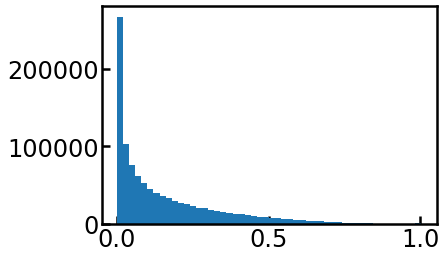

In [55]:
plt.hist((Rs**2).flatten(),bins=50)
plt.show()

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


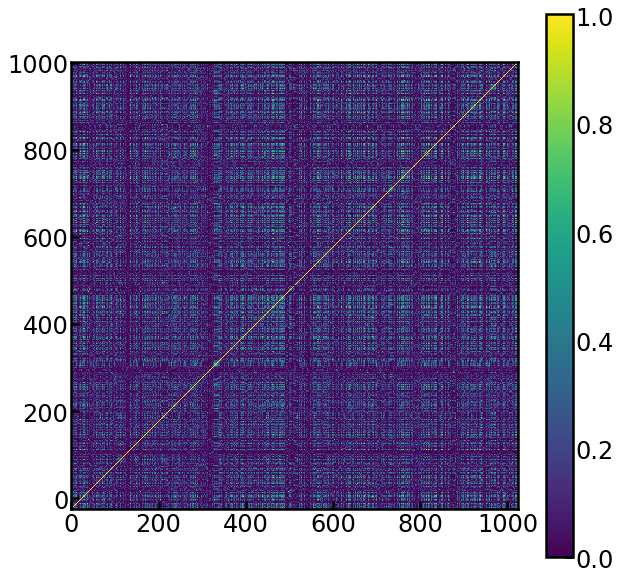

In [54]:
plt.figure(figsize=(10,10))
plt.imshow((Rs**2).astype(np.float32).T)
plt.colorbar()
plt.yticks([0,200,400,600,800,1000], [1000,800,600,400,200,0])
plt.show()


### Inflation without correction.

In [10]:
# inflation with no correction?
parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': False,
            'noise_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
            
        },
        'activations': {
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
        }
}
res = pipeline(activations, expression, parameters)
pickle.dump(res,open(corr_dir + 'no_correction.pickle', 'wb'))

  1%|          | 882/102400 [00:00<00:11, 8818.68it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 888/102400 [00:00<00:11, 8873.22it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:14<00:00, 7307.22it/s]


### Inflation regressing out PEER factors from expression

In [102]:
# Inflation after regressing out PEER factors
print ('Regress Peer')
results = []
n_peer = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
for k in n_peer:
    print (k)
    parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': k,
            'donor_cov_correct': False,
            'noise_correct': False,
            'sample_cov_correct': False
            
        },
        'activations': {
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
        }
}

    res = pipeline(activations, expression, parameters)
    results.append(res)
pickle.dump(results, open(corr_dir + 'regress_peer.pickle', 'wb'))

Regress Peer
1
Regressing out 1 PEER factors from expression


  0%|          | 444/102400 [00:00<00:22, 4439.81it/s]

Computing pvalues
Shuffle: real


  0%|          | 446/102400 [00:00<00:22, 4456.42it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4277.01it/s]


2
Regressing out 2 PEER factors from expression


  1%|          | 686/102400 [00:00<00:14, 6850.97it/s]

Computing pvalues
Shuffle: real


  1%|          | 675/102400 [00:00<00:15, 6748.91it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:18<00:00, 5624.12it/s]


3
Regressing out 3 PEER factors from expression


  0%|          | 451/102400 [00:00<00:22, 4509.39it/s]

Computing pvalues
Shuffle: real


  0%|          | 457/102400 [00:00<00:22, 4564.60it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:24<00:00, 4257.22it/s]


4
Regressing out 4 PEER factors from expression


  0%|          | 449/102400 [00:00<00:22, 4480.50it/s]

Computing pvalues
Shuffle: real


  0%|          | 450/102400 [00:00<00:22, 4498.42it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:24<00:00, 4257.23it/s]


5
Regressing out 5 PEER factors from expression


  0%|          | 448/102400 [00:00<00:22, 4472.35it/s]

Computing pvalues
Shuffle: real


  0%|          | 444/102400 [00:00<00:23, 4431.87it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:26<00:00, 3866.58it/s]


6
Regressing out 6 PEER factors from expression


  1%|          | 689/102400 [00:00<00:14, 6883.13it/s]

Computing pvalues
Shuffle: real


  1%|          | 680/102400 [00:00<00:14, 6793.53it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:15<00:00, 6569.10it/s]


7
Regressing out 7 PEER factors from expression


  1%|          | 680/102400 [00:00<00:14, 6797.30it/s]

Computing pvalues
Shuffle: real


  1%|          | 675/102400 [00:00<00:15, 6746.53it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:16<00:00, 6363.69it/s]


8
Regressing out 8 PEER factors from expression


  1%|          | 684/102400 [00:00<00:14, 6838.07it/s]

Computing pvalues
Shuffle: real


  0%|          | 447/102400 [00:00<00:22, 4466.92it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:24<00:00, 4235.27it/s]


9
Regressing out 9 PEER factors from expression


  0%|          | 448/102400 [00:00<00:22, 4477.98it/s]

Computing pvalues
Shuffle: real


  0%|          | 451/102400 [00:00<00:22, 4502.30it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4349.59it/s]


10
Regressing out 10 PEER factors from expression


  1%|          | 692/102400 [00:00<00:14, 6911.29it/s]

Computing pvalues
Shuffle: real


  0%|          | 457/102400 [00:00<00:22, 4560.90it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4298.11it/s]


11
Regressing out 11 PEER factors from expression


  0%|          | 456/102400 [00:00<00:22, 4555.35it/s]

Computing pvalues
Shuffle: real


  0%|          | 464/102400 [00:00<00:21, 4636.77it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4307.10it/s]


12
Regressing out 12 PEER factors from expression


  0%|          | 450/102400 [00:00<00:22, 4498.19it/s]

Computing pvalues
Shuffle: real


  0%|          | 455/102400 [00:00<00:22, 4542.61it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4281.18it/s]


13
Regressing out 13 PEER factors from expression


  0%|          | 449/102400 [00:00<00:22, 4489.40it/s]

Computing pvalues
Shuffle: real


  0%|          | 464/102400 [00:00<00:21, 4638.47it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4334.73it/s]


14
Regressing out 14 PEER factors from expression


  0%|          | 453/102400 [00:00<00:22, 4521.13it/s]

Computing pvalues
Shuffle: real


  0%|          | 454/102400 [00:00<00:22, 4538.68it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4284.34it/s]


15
Regressing out 15 PEER factors from expression


  0%|          | 458/102400 [00:00<00:22, 4578.80it/s]

Computing pvalues
Shuffle: real


  0%|          | 455/102400 [00:00<00:22, 4540.85it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4291.63it/s]


16
Regressing out 16 PEER factors from expression


  0%|          | 453/102400 [00:00<00:22, 4526.22it/s]

Computing pvalues
Shuffle: real


  0%|          | 457/102400 [00:00<00:22, 4562.39it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4314.93it/s]


17
Regressing out 17 PEER factors from expression


  0%|          | 462/102400 [00:00<00:22, 4614.69it/s]

Computing pvalues
Shuffle: real


  0%|          | 454/102400 [00:00<00:22, 4531.22it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4320.81it/s]


18
Regressing out 18 PEER factors from expression


  0%|          | 457/102400 [00:00<00:22, 4569.11it/s]

Computing pvalues
Shuffle: real


  0%|          | 454/102400 [00:00<00:22, 4533.34it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:24<00:00, 4211.12it/s]


19
Regressing out 19 PEER factors from expression


  0%|          | 454/102400 [00:00<00:22, 4538.35it/s]

Computing pvalues
Shuffle: real


  0%|          | 454/102400 [00:00<00:22, 4533.24it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:23<00:00, 4319.80it/s]


20
Regressing out 20 PEER factors from expression


  0%|          | 455/102400 [00:00<00:22, 4547.72it/s]

Computing pvalues
Shuffle: real


  1%|          | 686/102400 [00:00<00:14, 6851.81it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:15<00:00, 6573.95it/s]


21
Regressing out 21 PEER factors from expression


  1%|          | 662/102400 [00:00<00:15, 6617.13it/s]

Computing pvalues
Shuffle: real


  1%|          | 674/102400 [00:00<00:15, 6739.28it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:16<00:00, 6387.34it/s]


22
Regressing out 22 PEER factors from expression


  1%|          | 676/102400 [00:00<00:15, 6751.49it/s]

Computing pvalues
Shuffle: real


  1%|          | 703/102400 [00:00<00:14, 7020.45it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:15<00:00, 6478.91it/s]


23
Regressing out 23 PEER factors from expression


  1%|          | 674/102400 [00:00<00:15, 6731.08it/s]

Computing pvalues
Shuffle: real


  1%|          | 664/102400 [00:00<00:15, 6631.28it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:15<00:00, 6513.81it/s]


24
Regressing out 24 PEER factors from expression


  1%|          | 655/102400 [00:00<00:15, 6543.42it/s]

Computing pvalues
Shuffle: real


  1%|          | 677/102400 [00:00<00:15, 6766.70it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:15<00:00, 6518.22it/s]


25
Regressing out 25 PEER factors from expression


  1%|          | 686/102400 [00:00<00:14, 6853.72it/s]

Computing pvalues
Shuffle: real


  1%|          | 687/102400 [00:00<00:14, 6869.11it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:15<00:00, 6622.14it/s]


### Inflation regressing out donor confounders + tissue sample confounders

In [3]:
# Inflation after regressing out donor IDs and then 25 sample confounders in order of variance explained.
print ('Regress Confounders')
parameters= { 
    'expression': { 
        'gaussianize': False,
        'peer_correct': False,
        'donor_cov_correct': True,
        'sample_cov_correct': True
    },
    'activations': {
        'gaussianize': False,
        'peer_correct': False,
        'donor_cov_correct': True,
        'sample_cov_correct': True
    }
}

results = pipeline(activations, expression, parameters)
pickle.dump(results, open(corr_dir + 'regress_confounders.pickle', 'wb'))

Regress Confounders


  1%|          | 790/102400 [00:00<00:12, 7895.17it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 800/102400 [00:00<00:12, 7994.06it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7760.33it/s]


### Inflation regressing out donor confounders + tissue sample confounders only expression

In [23]:
print ('Regress Confounders only expression')
parameters= { 
    'expression': { 
        'gaussianize': False,
        'peer_correct': False,
        'donor_cov_correct': True,
        'sample_cov_correct': True
    },
    'activations': {
        'gaussianize': False,
        'peer_correct': False,
        'donor_cov_correct': False,
        'sample_cov_correct': False
    }
}

results = pipeline(activations, expression, parameters)
pickle.dump(results, open(corr_dir + 'regress_confounders_only_expression.pickle', 'wb'))

Regress Confounders only expression


  1%|          | 656/102400 [00:00<00:15, 6548.59it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 665/102400 [00:00<00:15, 6641.82it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:16<00:00, 6248.76it/s]


### Inflation regressing out donor confounders + tissue sample confounders only activations

In [24]:
print ('Regress Confounders only activations')
parameters= { 
    'expression': { 
        'gaussianize': False,
        'peer_correct': False,
        'donor_cov_correct': False,
        'sample_cov_correct': False
    },
    'activations': {
        'gaussianize': False,
        'peer_correct': False,
        'donor_cov_correct': True,
        'sample_cov_correct': True
    }
}

results = pipeline(activations, expression, parameters)
pickle.dump(results, open(corr_dir + 'regress_confounders_only_activations.pickle', 'wb'))

Regress Confounders only activations


  1%|          | 820/102400 [00:00<00:12, 8193.35it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 853/102400 [00:00<00:11, 8529.85it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8299.13it/s]


### Inflation after gaussianising activations

In [111]:
# How does gaussianizing the activations affect inflation?
print ('Gaussianize activations')
parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
            
        },
        'activations': {
            'gaussianize': True,
            'peer_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
        }
}
results = pipeline(activations, expression, parameters)
pickle.dump(results, open(corr_dir + 'gaussianize_activations.pickle', 'wb'))

Gaussianize activations
Gaussianizing


  1%|          | 580/102400 [00:00<00:17, 5794.70it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 632/102400 [00:00<00:16, 6315.61it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:17<00:00, 5983.77it/s]


### Inflation after regressing out noise

In [ ]:
# results = []
# for k in range(1,10):
#     print ("Regressing out {} noise covariates".format(k))
#     random_covariates = np.random.random(size=(291,k)) - 0.5
#     lr = LinearRegression()
#     lr.fit(random_covariates, expression)
#     res_expression = expression - lr.predict(random_covariates)
    
    
#     sorted_idx = np.argsort(res_expression.var(0))[::-1]
#     res_expression = res_expression.iloc[:,sorted_idx[0:100]]
    
#     res = compute_pearsonR(activations, res_expression.as_matrix())

#     results.append(res)
    
# Inflation after regressing out PEER factors
print ('Regress noise confounders')
results = []
n_noise = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]
for k in n_noise:
    print (k)
    parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': False,
            'noise_correct': k,
            'donor_cov_correct': True,
            'sample_cov_correct': True
            
        },
        'activations': {
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': True,
            'sample_cov_correct': True
        }
}

    res = pipeline(activations, expression, parameters)
    results.append(res)
pickle.dump(results, open(corr_dir + 'correct_confounders_regress_noise.pickle', 'wb'))

Regress noise confounders
1
Regressing out 1 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  2%|▏         | 1688/102400 [00:00<00:11, 8460.37it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7640.52it/s]


2
Regressing out 2 noise confounders from expression

  0%|          | 0/102400 [00:00<?, ?it/s]


Computing pearson R coefficients
Shuffle: real


  1%|          | 815/102400 [00:00<00:12, 8145.09it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8053.83it/s]


3
Regressing out 3 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 815/102400 [00:00<00:12, 8143.52it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7970.59it/s]


4
Regressing out 4 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 809/102400 [00:00<00:12, 8087.39it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8075.54it/s]


5
Regressing out 5 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 850/102400 [00:00<00:11, 8494.64it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8274.48it/s]


6
Regressing out 6 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 842/102400 [00:00<00:12, 8414.55it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7978.26it/s]


7
Regressing out 7 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 806/102400 [00:00<00:12, 8052.27it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7944.75it/s]


8
Regressing out 8 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 852/102400 [00:00<00:11, 8517.57it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8457.48it/s]


9
Regressing out 9 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 837/102400 [00:00<00:12, 8362.63it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8017.49it/s]


10
Regressing out 10 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 816/102400 [00:00<00:12, 8150.91it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7829.24it/s]


11
Regressing out 11 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 783/102400 [00:00<00:12, 7824.91it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7824.47it/s]


12
Regressing out 12 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 843/102400 [00:00<00:12, 8429.26it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8336.06it/s]


13
Regressing out 13 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  2%|▏         | 1655/102400 [00:00<00:12, 8282.28it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7733.31it/s]


14
Regressing out 14 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 822/102400 [00:00<00:12, 8212.65it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7991.06it/s]


15
Regressing out 15 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 769/102400 [00:00<00:13, 7684.84it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7994.91it/s]


16
Regressing out 16 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 840/102400 [00:00<00:12, 8396.86it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7840.51it/s]


17
Regressing out 17 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  0%|          | 448/102400 [00:00<00:24, 4224.50it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7546.14it/s]


18
Regressing out 18 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 792/102400 [00:00<00:12, 7918.37it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8120.23it/s]


19
Regressing out 19 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 802/102400 [00:00<00:12, 8010.31it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7702.40it/s]


20
Regressing out 20 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  2%|▏         | 1566/102400 [00:00<00:12, 7893.06it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7614.37it/s]


21
Regressing out 21 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 832/102400 [00:00<00:12, 8312.00it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7453.29it/s]


22
Regressing out 22 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 837/102400 [00:00<00:12, 8361.02it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7999.13it/s]


23
Regressing out 23 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 856/102400 [00:00<00:11, 8558.46it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8130.46it/s]


24
Regressing out 24 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 772/102400 [00:00<00:13, 7717.45it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7969.45it/s]


25
Regressing out 25 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 766/102400 [00:00<00:13, 7656.36it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7356.44it/s]


26
Regressing out 26 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 866/102400 [00:00<00:11, 8654.29it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:11<00:00, 8539.76it/s]


27
Regressing out 27 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 792/102400 [00:00<00:12, 7911.99it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7770.11it/s]


28
Regressing out 28 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 811/102400 [00:00<00:12, 8107.19it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7978.30it/s]


29
Regressing out 29 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 885/102400 [00:00<00:11, 8844.25it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8260.09it/s]


30
Regressing out 30 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  2%|▏         | 1652/102400 [00:00<00:12, 8294.63it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8094.18it/s]


31
Regressing out 31 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 773/102400 [00:00<00:13, 7722.11it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7719.38it/s]


32
Regressing out 32 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 834/102400 [00:00<00:12, 8337.48it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8025.18it/s]


33
Regressing out 33 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 786/102400 [00:00<00:12, 7859.39it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7843.30it/s]


34
Regressing out 34 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 831/102400 [00:00<00:12, 8306.92it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7372.72it/s]


35
Regressing out 35 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 772/102400 [00:00<00:13, 7714.95it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8087.37it/s]


36
Regressing out 36 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 780/102400 [00:00<00:13, 7798.84it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7904.32it/s]


37
Regressing out 37 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 872/102400 [00:00<00:11, 8718.66it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:11<00:00, 8634.26it/s]


38
Regressing out 38 noise confounders from expression


  0%|          | 0/102400 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 832/102400 [00:00<00:12, 8319.00it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8390.90it/s]


39
Regressing out 39 noise confounders from expression


In [6]:
pickle.dump(results, open(corr_dir + 'regress_noise.pickle', 'wb'))

### Inflation after regressing out donor + tissue samples confounders with PEER factors

In [65]:
# Inflation after regressing out PEER factors
print ('Regress confounders regress Peer')
results = []
n_peer = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]
for k in n_peer:
    print (k)
    parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': k,
            'donor_cov_correct': True,
            'sample_cov_correct': True
            
        },
        'activations': {
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': True,
            'sample_cov_correct': True
        }
}

    res = pipeline(activations, expression, parameters)
    results.append(res)
pickle.dump(results, open(corr_dir + 'correct_confounders_regress_peer.pickle', 'wb'))

Regress confounders regress Peer
1
Regressing out 1 PEER factors from expression


  1%|          | 847/102400 [00:00<00:11, 8463.23it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 588/102400 [00:00<00:17, 5870.66it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:14<00:00, 7068.38it/s]


2
Regressing out 2 PEER factors from expression


  1%|          | 850/102400 [00:00<00:11, 8494.18it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 852/102400 [00:00<00:11, 8514.41it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8140.78it/s]


3
Regressing out 3 PEER factors from expression


  1%|          | 771/102400 [00:00<00:13, 7705.82it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 743/102400 [00:00<00:13, 7426.32it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:16<00:00, 6155.54it/s]


4
Regressing out 4 PEER factors from expression


  1%|          | 876/102400 [00:00<00:11, 8757.13it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 816/102400 [00:00<00:12, 8159.19it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8157.18it/s]


5
Regressing out 5 PEER factors from expression


  1%|          | 813/102400 [00:00<00:12, 8125.13it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 794/102400 [00:00<00:12, 7934.52it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7753.36it/s]


6
Regressing out 6 PEER factors from expression


  1%|          | 857/102400 [00:00<00:11, 8567.50it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 821/102400 [00:00<00:12, 8207.33it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8154.96it/s]


7
Regressing out 7 PEER factors from expression


  1%|          | 791/102400 [00:00<00:12, 7908.27it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 816/102400 [00:00<00:12, 8157.25it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7808.19it/s]


8
Regressing out 8 PEER factors from expression


  1%|          | 836/102400 [00:00<00:12, 8352.40it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 827/102400 [00:00<00:12, 8262.66it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8131.99it/s]


9
Regressing out 9 PEER factors from expression


  1%|          | 798/102400 [00:00<00:12, 7977.61it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 790/102400 [00:00<00:12, 7898.71it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7809.95it/s]


10
Regressing out 10 PEER factors from expression


  1%|          | 812/102400 [00:00<00:12, 8112.10it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 823/102400 [00:00<00:12, 8221.46it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8328.62it/s]


11
Regressing out 11 PEER factors from expression


  1%|          | 797/102400 [00:00<00:12, 7962.19it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 798/102400 [00:00<00:12, 7970.24it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:14<00:00, 7288.64it/s]


12
Regressing out 12 PEER factors from expression


  1%|          | 828/102400 [00:00<00:12, 8275.61it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 827/102400 [00:00<00:12, 8266.74it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8059.14it/s]


13
Regressing out 13 PEER factors from expression


  1%|          | 795/102400 [00:00<00:12, 7940.43it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 798/102400 [00:00<00:12, 7973.35it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7782.23it/s]


14
Regressing out 14 PEER factors from expression


  1%|          | 814/102400 [00:00<00:12, 8132.58it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 816/102400 [00:00<00:12, 8150.68it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8099.30it/s]


15
Regressing out 15 PEER factors from expression


  1%|          | 771/102400 [00:00<00:13, 7700.22it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 818/102400 [00:00<00:12, 8173.79it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7793.01it/s]


16
Regressing out 16 PEER factors from expression


  1%|          | 800/102400 [00:00<00:12, 7999.45it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 825/102400 [00:00<00:12, 8245.09it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8148.76it/s]


17
Regressing out 17 PEER factors from expression


  1%|          | 783/102400 [00:00<00:12, 7828.40it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 791/102400 [00:00<00:12, 7904.71it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7702.62it/s]


18
Regressing out 18 PEER factors from expression


  1%|          | 862/102400 [00:00<00:11, 8613.35it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 843/102400 [00:00<00:12, 8428.52it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8186.50it/s]


19
Regressing out 19 PEER factors from expression


  1%|          | 790/102400 [00:00<00:12, 7899.24it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 782/102400 [00:00<00:13, 7816.32it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7636.19it/s]


20
Regressing out 20 PEER factors from expression


  1%|          | 730/102400 [00:00<00:13, 7290.38it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 824/102400 [00:00<00:12, 8233.37it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8036.85it/s]


21
Regressing out 21 PEER factors from expression


  1%|          | 824/102400 [00:00<00:12, 8232.84it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 830/102400 [00:00<00:12, 8293.62it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8065.07it/s]


22
Regressing out 22 PEER factors from expression


  1%|          | 765/102400 [00:00<00:13, 7647.58it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 776/102400 [00:00<00:13, 7757.79it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:15<00:00, 6771.81it/s]


23
Regressing out 23 PEER factors from expression


  1%|          | 795/102400 [00:00<00:12, 7946.52it/s]

Computing pearson R coefficients
Shuffle: real


  2%|▏         | 1543/102400 [00:00<00:13, 7746.62it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7624.28it/s]


24
Regressing out 24 PEER factors from expression


  1%|          | 801/102400 [00:00<00:12, 8003.90it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 815/102400 [00:00<00:12, 8144.67it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7931.29it/s]


25
Regressing out 25 PEER factors from expression


  1%|          | 815/102400 [00:00<00:12, 8143.31it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 805/102400 [00:00<00:12, 8049.47it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7848.64it/s]


26
Regressing out 26 PEER factors from expression


  1%|          | 840/102400 [00:00<00:12, 8391.98it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 834/102400 [00:00<00:12, 8333.61it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7846.33it/s]


27
Regressing out 27 PEER factors from expression


  1%|          | 813/102400 [00:00<00:12, 8129.08it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 821/102400 [00:00<00:12, 8207.99it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7912.98it/s]


28
Regressing out 28 PEER factors from expression


  1%|          | 785/102400 [00:00<00:12, 7845.13it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 825/102400 [00:00<00:12, 8241.38it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7814.41it/s]


29
Regressing out 29 PEER factors from expression


  1%|          | 691/102400 [00:00<00:14, 6901.93it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 808/102400 [00:00<00:12, 8072.60it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7857.94it/s]


30
Regressing out 30 PEER factors from expression


  1%|          | 791/102400 [00:00<00:12, 7904.47it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 796/102400 [00:00<00:12, 7951.42it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7718.76it/s]


31
Regressing out 31 PEER factors from expression


  1%|          | 803/102400 [00:00<00:12, 8020.77it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 811/102400 [00:00<00:12, 8108.52it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7832.14it/s]


32
Regressing out 32 PEER factors from expression


  1%|          | 821/102400 [00:00<00:12, 8201.44it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 827/102400 [00:00<00:12, 8261.70it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7861.30it/s]


33
Regressing out 33 PEER factors from expression


  1%|          | 814/102400 [00:00<00:12, 8131.25it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 826/102400 [00:00<00:12, 8258.63it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7971.02it/s]


34
Regressing out 34 PEER factors from expression


  1%|          | 810/102400 [00:00<00:12, 8099.56it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 809/102400 [00:00<00:12, 8084.07it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7805.81it/s]


35
Regressing out 35 PEER factors from expression


  1%|          | 831/102400 [00:00<00:12, 8308.38it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 839/102400 [00:00<00:12, 8383.89it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 8162.06it/s]


36
Regressing out 36 PEER factors from expression


  1%|          | 799/102400 [00:00<00:12, 7981.52it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 788/102400 [00:00<00:12, 7876.98it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7735.97it/s]


37
Regressing out 37 PEER factors from expression


  1%|          | 770/102400 [00:00<00:13, 7695.95it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 769/102400 [00:00<00:13, 7686.07it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:14<00:00, 7085.30it/s]


38
Regressing out 38 PEER factors from expression


  1%|          | 782/102400 [00:00<00:13, 7811.14it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 791/102400 [00:00<00:12, 7908.40it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7739.16it/s]


39
Regressing out 39 PEER factors from expression


  1%|          | 837/102400 [00:00<00:12, 8362.93it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 794/102400 [00:00<00:12, 7938.06it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:12<00:00, 7950.82it/s]


40
Regressing out 40 PEER factors from expression


  1%|          | 778/102400 [00:00<00:13, 7776.86it/s]

Computing pearson R coefficients
Shuffle: real


  1%|          | 805/102400 [00:00<00:12, 8041.30it/s]

Shuffle: shuffle


100%|██████████| 102400/102400 [00:13<00:00, 7762.38it/s]


## Plotting

### Inflation no correction

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


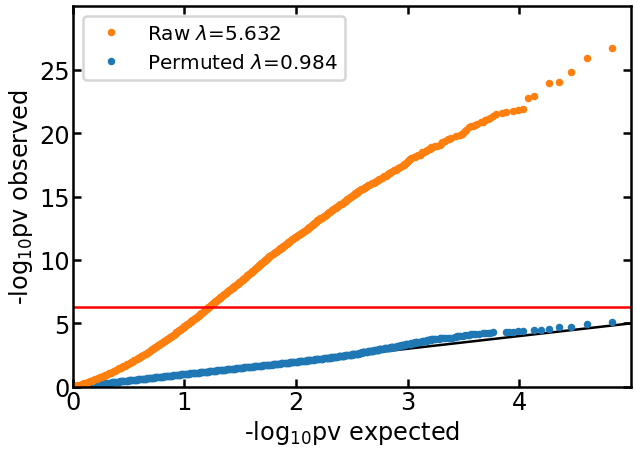

In [7]:
no_correction = pickle.load(open(corr_dir + 'no_correction.pickle', 'rb'))
labels = ['Raw', 'Permuted']
pv = []
label = []
for i in [1,2]:
    flat_pvalues = no_correction[i].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = estimate_lambda(flat_pvalues)
    pv.extend(flat_pvalues)
    label.extend(['{} $\lambda$={:0.4}'.format(labels[i-1], lamb)] * len(flat_pvalues))
    

df = pd.DataFrame(data=dict(pv=pv, label=label))

limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,5],[0,30]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=20, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')
plt.show()

### Inflation after regressing out PEER factors from expression

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


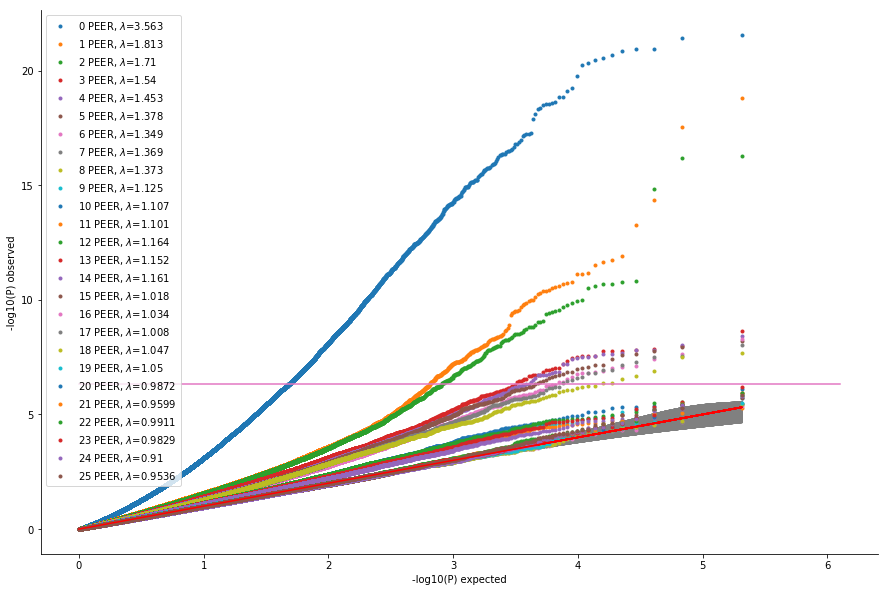

In [107]:
plt.figure(1, figsize=(15,10))
no_correction = pickle.load(open(corr_dir + 'no_correction.pickle', 'rb'))
regress_peer = pickle.load(open(corr_dir + 'regress_peer.pickle', 'rb'))
regress_peer = [no_correction] + regress_peer
n_PEERs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
lambdas = []
for (i, res) in enumerate(regress_peer):
    flat_pvalues = res[1].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = estimate_lambda(flat_pvalues)
    lambdas.append(lamb)
    qqplot(flat_pvalues, label=r'{} PEER, $\lambda$={:0.4}'.format(n_PEERs[i], lamb))
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold])
plt.legend(loc='upper left')

#### Shuffled

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


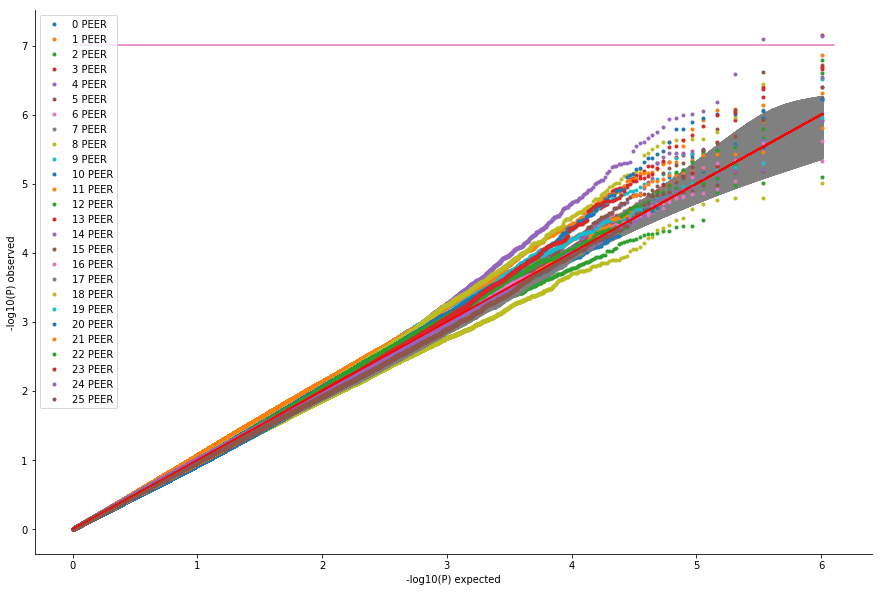

In [14]:
plt.figure(1, figsize=(15,10))
no_correction = pickle.load(open(corr_dir + 'no_correction.pickle', 'rb'))
regress_peer = pickle.load(open(corr_dir + 'regress_peer.pickle', 'rb'))
regress_peer = [no_correction] + regress_peer
n_PEERs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
for (i, res) in enumerate(regress_peer):
    flat_pvalues = res[2].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
#     lamb = estimate_lambda(flat_pvalues)
    lambdas.append(lamb)
    qqplot(flat_pvalues, label=r'{} PEER'.format(n_PEERs[i]))
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold])
plt.legend(loc='upper left')

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


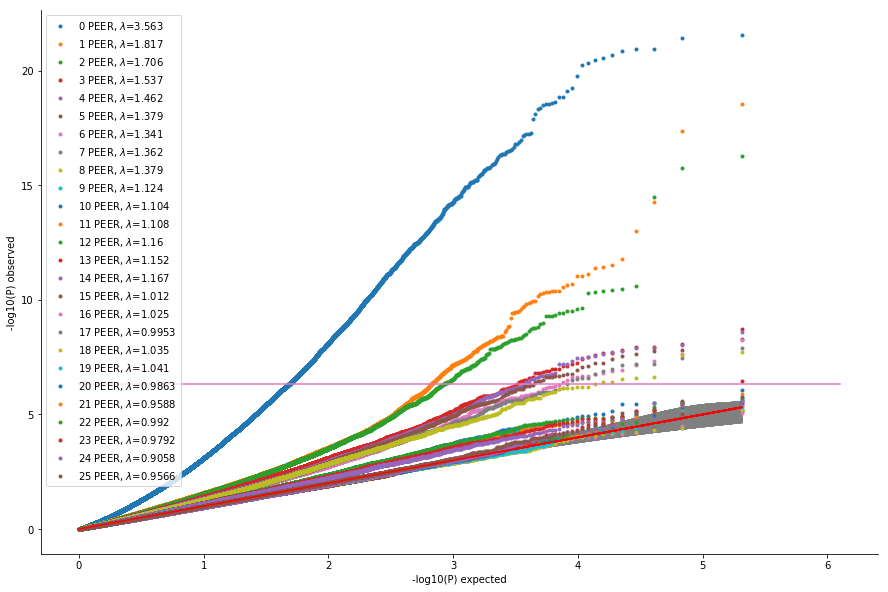

In [101]:
plt.figure(1, figsize=(15,10))
no_correction = pickle.load(open(corr_dir + 'no_correction.pickle', 'rb'))
regress_peer = pickle.load(open(corr_dir + 'regress_peer_gaussianize.pickle', 'rb'))
regress_peer = [no_correction] + regress_peer
n_PEERs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
lambdas = [ 3.56250504,  1.8166396 ,  1.70648788,  1.53705674,  1.4619652 ,
        1.37949137,  1.34050583,  1.36233392,  1.37897257,  1.12382489,
        1.10365063,  1.10837035,  1.1599699 ,  1.152051  ,  1.16692426,
        1.01199453,  1.02525495,  0.99531421,  1.03468401,  1.04122192,
        0.98629846,  0.95884121,  0.99204178,  0.97923701,  0.90580677,
        0.95661171]
for (i, res) in enumerate(regress_peer):
    flat_pvalues = res[1].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
#     lamb = estimate_lambda(flat_pvalues)
#     lambdas.append(lamb)
    qqplot(flat_pvalues, label=r'{} PEER, $\lambda$={:0.4}'.format(n_PEERs[i], lambdas[i]))
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold])
plt.legend(loc='upper left')

### Inflation after regressing out confounders

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


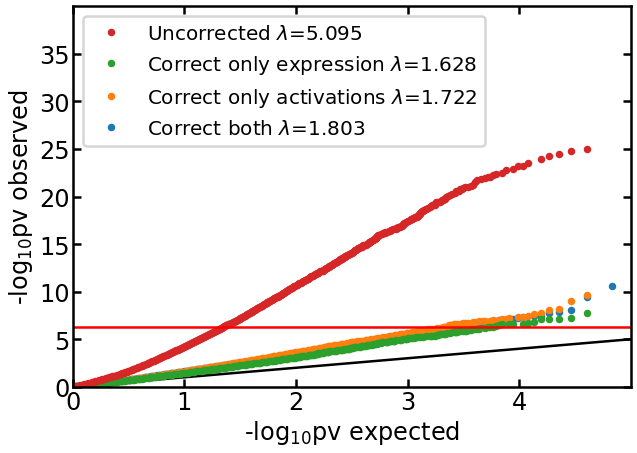

In [108]:
plt.figure(1, figsize=(10,7))
no_correction = pickle.load(open(corr_dir + 'no_correction.pickle', 'rb'))
regress_cov = pickle.load(open(corr_dir + 'regress_confounders.pickle', 'rb'))
regress_cov_only_exp = pickle.load(open(corr_dir + 'regress_confounders_only_expression.pickle', 'rb'))
regress_cov_only_act = pickle.load(open(corr_dir + 'regress_confounders_only_activations.pickle', 'rb'))
regress_cov = [no_correction] + [regress_cov_only_exp] + [regress_cov_only_act] + [regress_cov]

conditions = ['Uncorrected', 'Correct only expression', 'Correct only activations', 'Correct both']
pv = []
label = []
for (i, res) in enumerate(regress_cov):
    flat_pvalues = regress_cov[i][1].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = estimate_lambda(flat_pvalues)
    pv.extend(flat_pvalues)
    label.extend(['{} $\lambda$={:0.4}'.format(conditions[i], lamb)] * len(flat_pvalues))


df = pd.DataFrame(data=dict(pv=pv, label=label))

limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,5],[0,40]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=20, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')
plt.show()


### Inflation after gaussianizing activations

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


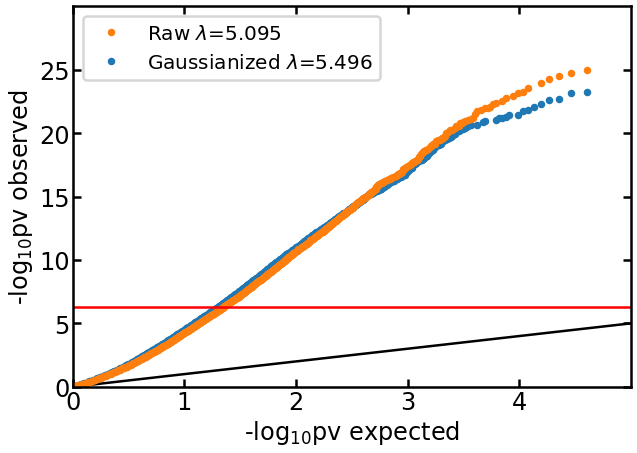

In [94]:
no_correction = pickle.load(open(corr_dir + 'no_correction.pickle', 'rb'))
gaussianize_activations = pickle.load(open(corr_dir + 'gaussianize_activations.pickle', 'rb'))
gaussianize_activations = [no_correction]  + [gaussianize_activations]


labels = ['Raw', 'Gaussianized']
pv = []
label = []
for (i, res) in enumerate(gaussianize_activations):
    flat_pvalues = res[1].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = estimate_lambda(flat_pvalues)
    pv.extend(flat_pvalues)
    label.extend(['{} $\lambda$={:0.4}'.format(labels[i], lamb)] * len(flat_pvalues))
pv.reverse()
label.reverse()
    

df = pd.DataFrame(data=dict(pv=pv, label=label))

limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,5],[0,30]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=20, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')
plt.show()


### Inflation after regressing out donor + tissue samples confounders with PEER factors

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


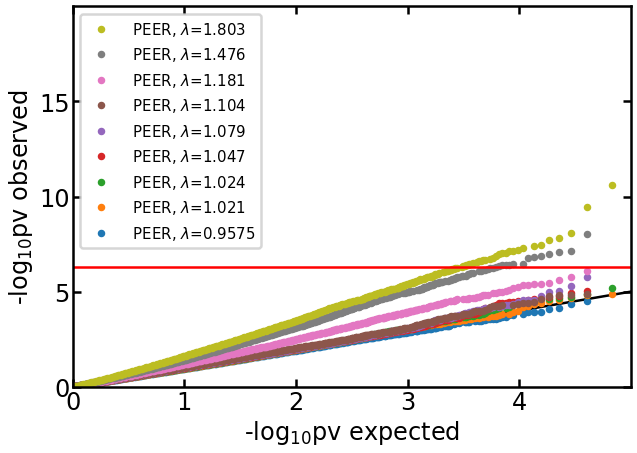

In [113]:
plt.figure(1, figsize=(15,10))
regress_cov = pickle.load(open(corr_dir + 'regress_confounders.pickle', 'rb'))
regress_peer = pickle.load(open(corr_dir + 'correct_confounders_regress_peer.pickle', 'rb'))
regress_peer = [regress_cov] + regress_peer
n_PEERs = [0,5,10,15,20,25,30,35,40]

pv = []
label = []
lambdas = [1.803, 1.476, 1.181, 1.104, 1.079, 1.047, 1.024, 1.021, 0.9575]
for (i, res) in enumerate([regress_peer[k] for k in n_PEERs]):
    flat_pvalues = res[1].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = lambdas[i]
    pv.extend(flat_pvalues)
    label.extend([' PEER, $\lambda$={:0.4}'.format(lamb)] * len(flat_pvalues))
    
df = pd.DataFrame(data=dict(pv=pv, label=label))

limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,5],[0,20]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=15, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')
plt.show()

### Inflation after regressing out noise

In [6]:
plt.figure(1, figsize=(15,10))
regress_cov = pickle.load(open(corr_dir + 'regress_confounders.pickle', 'rb'))
regress_noise = pickle.load(open(corr_dir + 'correct_confounders_regress_noise.pickle', 'rb'))
regress_noise = [regress_cov] + regress_noise
n_noise = [0,5,10,15,20,25,30,35,40]

pv = []
label = []
# lambdas = [1.803, 1.476, 1.181, 1.104, 1.079, 1.047, 1.024, 1.021, 0.9575]
for (i, res) in enumerate([regress_noise[k] for k in n_noise]):
    flat_pvalues = res[1].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = estimate_lambda(flat_pvalues)
    pv.extend(flat_pvalues)
    label.extend(['{:2d} noise confounders $\lambda$={:1.4}'.format(n_noise[i], lamb)] * len(flat_pvalues))
pv.reverse()
label.reverse()

    
df = pd.DataFrame(data=dict(pv=pv, label=label))

limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,5],[0,20]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=15, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')
plt.show()

KeyboardInterrupt: 

## Investigating PEER factors

### Cross correlating PEER

In [230]:
peer = PEER_factors.as_matrix()
mu = peer.mean(0)
num = np.matmul((peer - mu).T, (peer - mu))
sigmas = np.sqrt(np.sum((peer - mu)**2, axis=0))
Rs = np.zeros_like(num)
for i in range(60):
    for j in range(60):
        Rs[59-i,j] = num[i,j] / (sigmas[i]*sigmas[j])


/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


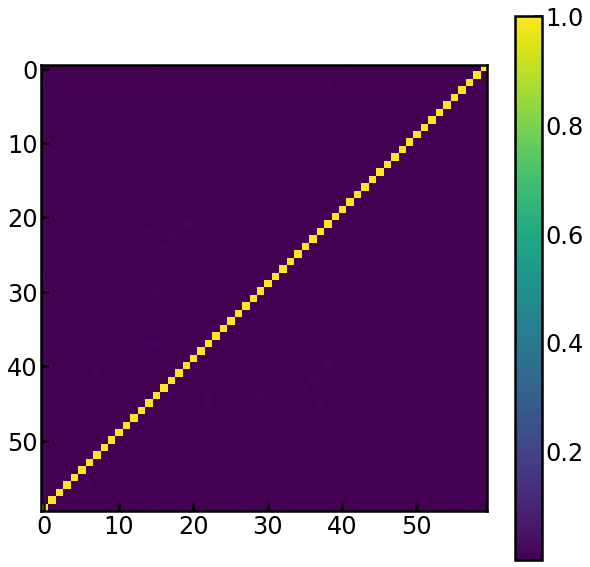

In [232]:
plt.figure(figsize=(10,10))
plt.imshow((Rs**2).astype(np.float32).T)
plt.colorbar()
# plt.yticks([0,200,400,600,800,1000], [1000,800,600,400,200,0])
plt.show()


### Correlating PEER to all confounders

 30%|███       | 784/2580 [00:00<00:00, 7831.88it/s]

Shuffle: real


 31%|███▏      | 807/2580 [00:00<00:00, 8067.99it/s]

Shuffle: shuffle


100%|██████████| 2580/2580 [00:00<00:00, 7760.46it/s]
/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


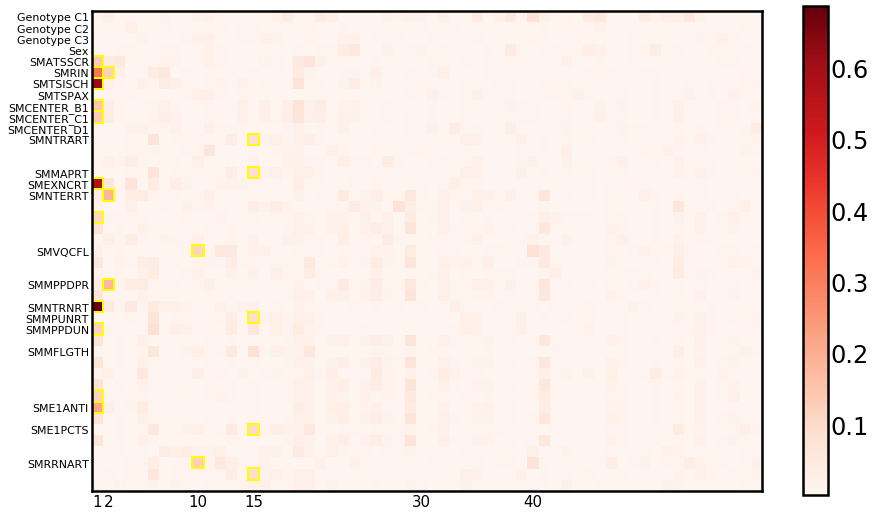

In [14]:
confounders = pd.concat([donor_confounders.loc[RNA_sample_donors], sample_confounders.loc[RNA_sample_donors], RNA_sample_covariates.iloc[:,1:]],axis=1)
results = compute_pearsonR(confounders.as_matrix(), PEER_factors.loc[RNA_sample_donors].as_matrix())

from matplotlib.patches import Rectangle
plt.figure(figsize=(15,9))
plt.imshow(results[0]**2, cmap='Reds')
ax = plt.subplot(111)
plt.colorbar()

#RNA expression confounders
y_locs = [0,3,4,5,10,13,15,16,17,19,24,26,29,30]
donor_and_sample_confounders = ['Genotype C1', 'Genotype C2', 'Genotype C3', 'Sex', 'SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1']
plt.yticks(list(range(11)) + [x + 11 for x in y_locs], donor_and_sample_confounders + [RNA_sample_covariates.columns[i] for i in y_locs][1:], size=11)

# ['Genotype C1', 'Genotype C2', 'Genotype C3', 'Sex', 'SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1']
# plt.yticks(range(7), ['SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1'], size=15)
plt.xticks([0,1, 9, 14, 29,39], [1,2, 10, 15,30,40], size=15)
plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')

bonf_threshold = 0.01 / len(results[1].T.flatten())
for loc in np.argwhere(results[1].T < bonf_threshold):
    ax.add_patch(Rectangle((-0.5 + loc[0],-0.5 + loc[1]), 1, 1, fill=False, edgecolor='yellow', lw=2))

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


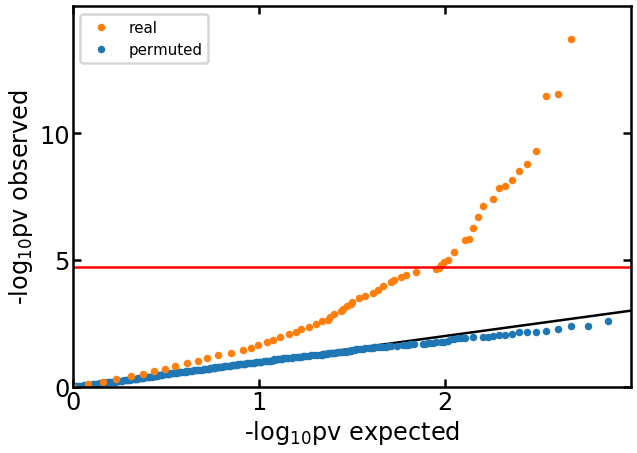

In [28]:
labels = ['real', 'permuted']
pv = []
label = []
for i in [1,2]:
    flat_pvalues = results[i].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = estimate_lambda(flat_pvalues)
    pv.extend(flat_pvalues)
    label.extend([labels[i-1]] * len(flat_pvalues))
plt.figure(2,figsize=(5,10))


df = pd.DataFrame(data=dict(pv=pv, label=label))
limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,3],[0,15]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=15, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')

### Correlating PEER to image feature PCs

  5%|▍         | 597/12000 [00:00<00:01, 5962.27it/s]

Shuffle: real


  5%|▌         | 610/12000 [00:00<00:01, 6098.14it/s]

Shuffle: shuffle


100%|██████████| 12000/12000 [00:02<00:00, 5888.33it/s]
/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


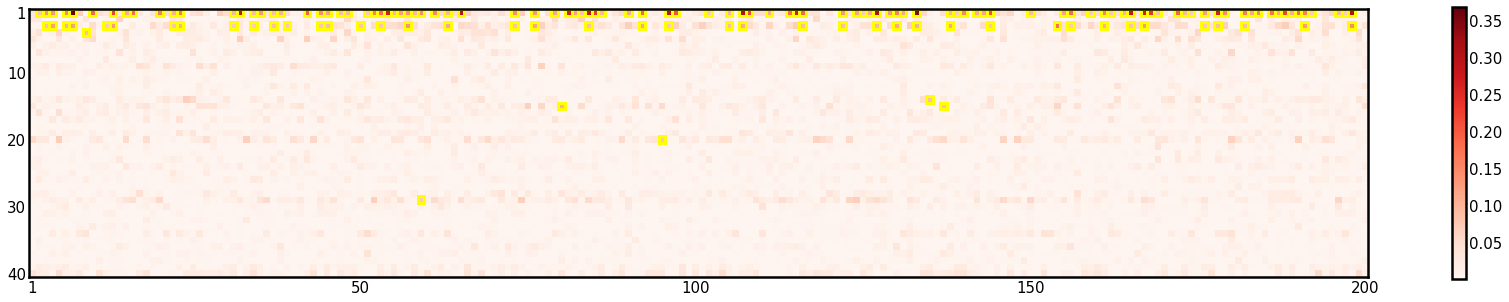

In [98]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.patches import Rectangle
plt.figure(figsize=(30,5))

results = compute_pearsonR(activations[:,0:200], PEER_factors.as_matrix())

components_df = pd.DataFrame(components)
components_df.index = donor_intersection

ax = plt.subplot(111)
plt.imshow((results[0].T**2)[0:40,:], cmap='Reds')
plt.colorbar()

bonf_threshold = 0.05 / len(results[1].flatten())
for loc in np.argwhere(results[1].T < bonf_threshold):
#     print (loc)
    ax.add_patch(Rectangle((-0.5 + loc[1],-0.5 + loc[0]), 1, 1, fill=False, edgecolor='yellow', lw=3))

y_locs = [1,4,5,6,11,14,16,17,18,20,25,27,30,31]
plt.yticks([0,9,19,29,39], ['1','10','20','30','40'], size=15)
plt.xticks([0,49,99,149,199], ['1','50','100','150','200'] , size=15)
plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')    
plt.show()

  0%|          | 0/12000 [00:00<?, ?it/s]

Shuffle: real


  7%|▋         | 886/12000 [00:00<00:01, 8851.19it/s]

Shuffle: shuffle


100%|██████████| 12000/12000 [00:01<00:00, 8465.90it/s]
/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


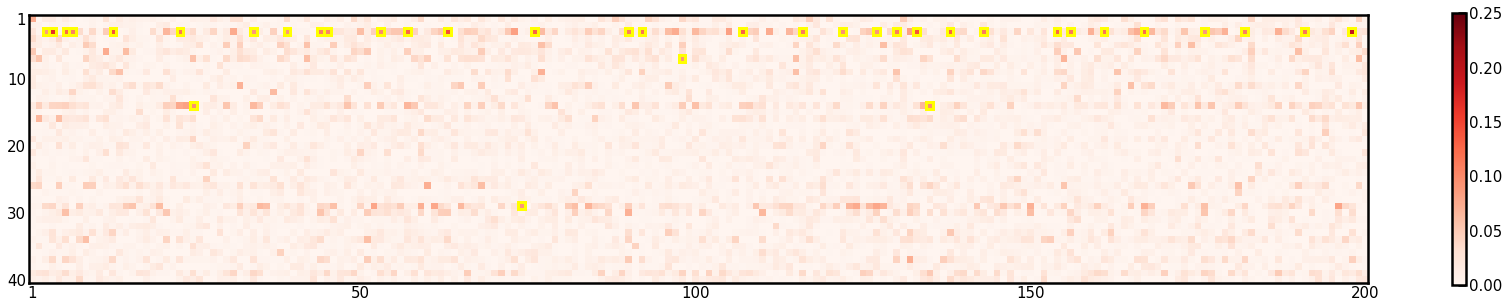

[2 2]
0.039
[2 3]
3.5e-07
[2 5]
0.00014
[2 6]
0.0019


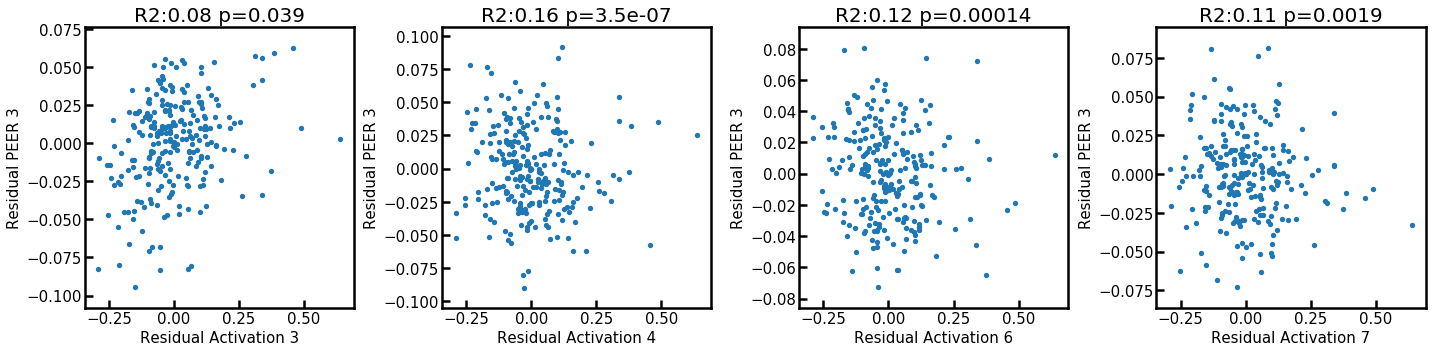

In [115]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.patches import Rectangle


activations_df = pd.DataFrame(activations)
activations_df.index = donor_intersection

lr_activations = LinearRegression()
lr_activations.fit(confounders.as_matrix(), activations_df.loc[RNA_sample_donors].as_matrix())
activations_c = activations_df.loc[RNA_sample_donors].as_matrix() - lr_activations.predict(confounders.as_matrix())

lr_peer = LinearRegression()
lr_peer.fit(confounders.as_matrix(), PEER_factors.loc[RNA_sample_donors].as_matrix())
PEER_factors_c = PEER_factors.loc[RNA_sample_donors].as_matrix() - lr_peer.predict(confounders.as_matrix())


results = compute_pearsonR(activations_c[:,0:200], PEER_factors_c)

plt.figure(figsize=(30,5))

ax = plt.subplot(111)
plt.imshow((results[0].T[0:40,0:200]**2), cmap='Reds', vmin=0, vmax=0.25)
plt.colorbar()

bonf_threshold = 0.05 / len(results[1].flatten())
for loc in np.argwhere(results[1].T < bonf_threshold):
#     print (loc)
    ax.add_patch(Rectangle((-0.5 + loc[1],-0.5 + loc[0]), 1, 1, fill=False, edgecolor='yellow', lw=3))

y_locs = [1,4,5,6,11,14,16,17,18,20,25,27,30,31]
plt.yticks([0,9,19,29,39], ['1','10','20','30','40'], size=15)
plt.xticks([0,49,99,149,199], ['1','50','100','150','200'] , size=15)
plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')    
plt.show()

import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig, axis = plt.subplots(1,4,figsize=(20,5))
for (k,loc) in enumerate(np.argwhere(results[1].T < bonf_threshold)[0:4]):
    i,j = loc
    print(loc)
    correlation = pearsonr(activations_c[:,j], PEER_factors_c[:,i])
    R2 = '{:0.2f}'.format(correlation[0]**2)
    pv = '{:0.2}'.format(correlation[1]*len(results[1].flatten()))
    print(pv)
    axis[k].set_title('R2:{} p={}'.format(R2,pv), size=20)
    axis[k].scatter(activations_c[:,i], PEER_factors_c[:,j],s=8)
    axis[k].set_xlabel('Residual Activation {}'.format(j + 1),size=15 )
    axis[k].set_ylabel('Residual PEER {}'.format(i + 1),size=15 )
plt.tight_layout()

## PEER to image features

## Correlating Image feature PCs to PEER after correction

  0%|          | 0/2880 [00:00<?, ?it/s]

Shuffle: real


 30%|██▉       | 855/2880 [00:00<00:00, 8546.18it/s]

Shuffle: shuffle


100%|██████████| 2880/2880 [00:00<00:00, 8110.14it/s]


[0 2]
0.005
[2 8]
0.0073
[4 2]
0.028
[6 5]
0.046


/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


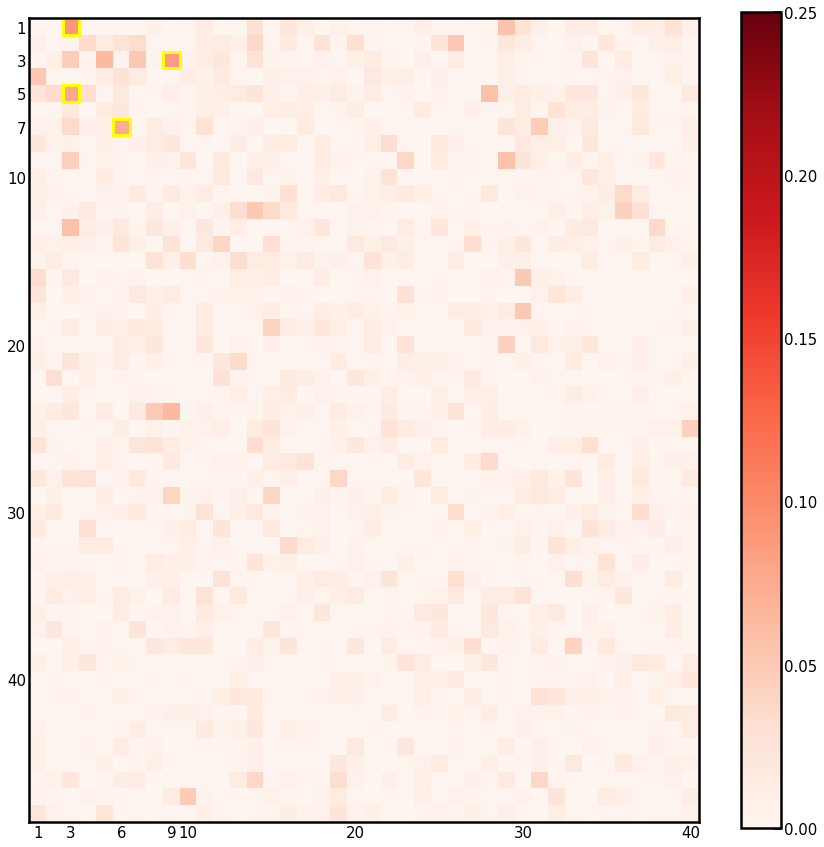

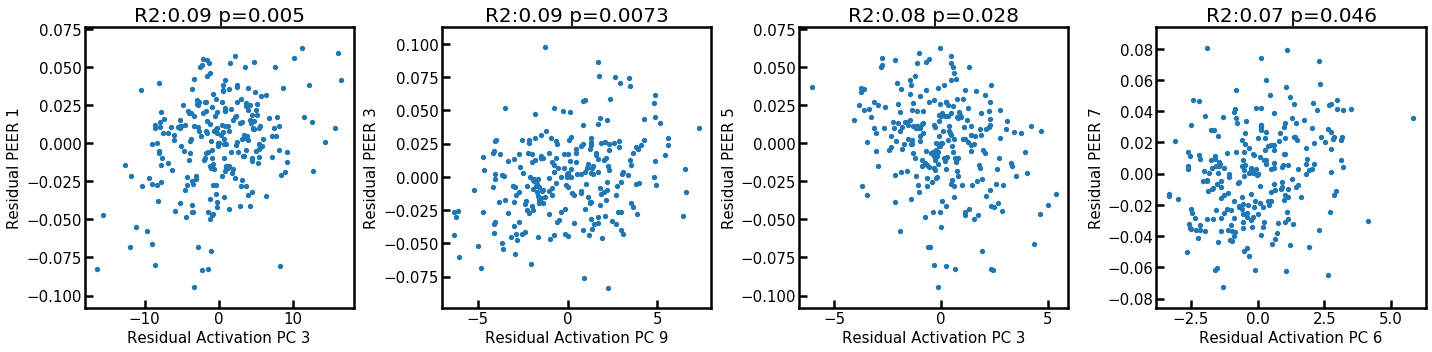

In [114]:
pca = PCA(n_components=0.99)
components = pca.fit_transform(activations)

components_df = pd.DataFrame(components)
components_df.index = donor_intersection

confounders = pd.concat([donor_confounders.loc[RNA_sample_donors], sample_confounders.loc[RNA_sample_donors], RNA_sample_covariates.iloc[:,1:]],axis=1)

lr_peer = LinearRegression()
lr_image_pcs = LinearRegression()
lr_peer.fit(confounders.as_matrix(), PEER_factors.loc[RNA_sample_donors].as_matrix())
lr_image_pcs.fit(confounders.as_matrix(), components_df.loc[RNA_sample_donors].as_matrix())

PEER_factors_c = PEER_factors.loc[RNA_sample_donors].as_matrix() - lr_peer.predict(confounders.as_matrix())
components_c = components_df.loc[RNA_sample_donors].as_matrix() - lr_image_pcs.predict(confounders.as_matrix())

results = compute_pearsonR(components_c, PEER_factors_c)

from matplotlib.patches import Rectangle
plt.figure(figsize=(15,15))
plt.imshow((results[0]**2)[:, 0:40], cmap='Reds', vmin=0, vmax=0.25)
ax = plt.subplot(111)
plt.colorbar()

plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')
bonf_threshold = 0.05 / len(results[1].T.flatten())
for loc in np.argwhere(results[1].T < bonf_threshold):
#     print (loc)
    ax.add_patch(Rectangle((-0.5 + loc[0],-0.5 + loc[1]), 1, 1, fill=False, edgecolor='yellow', lw=3))
    
# y_locs = [1,4,5,6,11,14,16,17,18,20,25,27,30,31]
plt.xticks([0,2,5,8,9,19,29,39],[1,3,6,9,10,20,30,40] , size=15)
plt.yticks([0,2,4,6,9,19,29,39],[1,3,5,7,10,20,30,40] , size=15)
plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')

import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig, axis = plt.subplots(1,4,figsize=(20,5))
for (k,loc) in enumerate(np.argwhere(results[1] < bonf_threshold)):
    i,j = loc
    print(loc)
    correlation = pearsonr(components_c[:,i], PEER_factors_c[:,j])
    R2 = '{:0.2f}'.format(correlation[0]**2)
    pv = '{:0.2}'.format(correlation[1]*len(results[1].flatten()))
    print(pv)
    axis[k].set_title('R2:{} p={}'.format(R2,pv), size=20)
    axis[k].scatter(components_c[:,i], PEER_factors_c[:,j],s=8)
    axis[k].set_xlabel('Residual Activation PC {}'.format(j + 1),size=15 )
    axis[k].set_ylabel('Residual PEER {}'.format(i + 1),size=15 )
plt.tight_layout()

### Correlating tissue sample confounders to image features PCs

In [83]:
pca = PCA(n_components=0.99)
components = pca.fit_transform(activations)
results = compute_pearsonR( confounders.as_matrix(), components[[donor_intersection.index(x) for x in RNA_sample_donors],:])

  0%|          | 0/2112 [00:00<?, ?it/s]

Shuffle: real


100%|██████████| 2112/2112 [00:00<00:00, 14333.45it/s]

Shuffle: shuffle


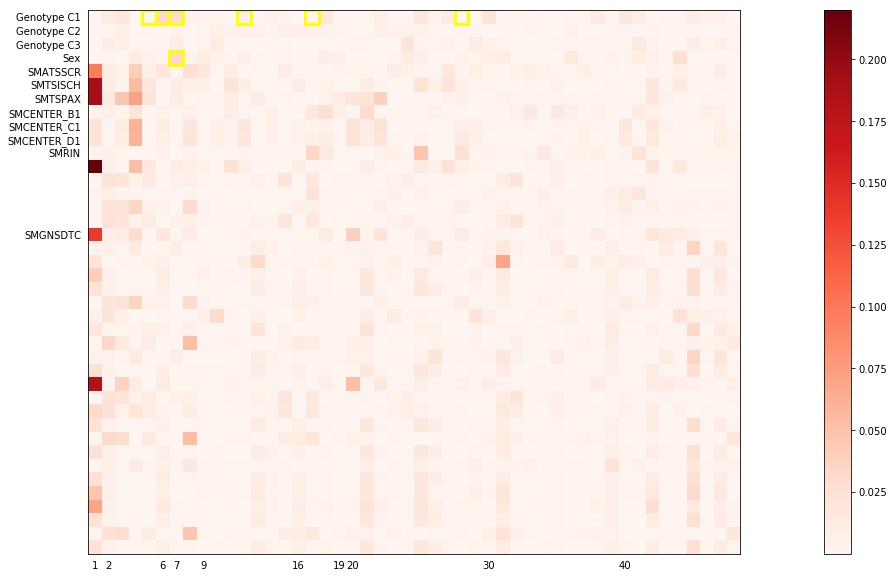

In [86]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(30,10))
plt.imshow((results[0]**2)[0:40, 0:200], cmap='Reds')
# plt.imshow(-np.log10(results[1].T)[0:40,0:50], cmap='Reds')
ax = plt.subplot(111)
plt.colorbar()

plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')
bonf_threshold = 0.05 / len(results[1].flatten())
for loc in np.argwhere(results[1].T < bonf_threshold):
#     print (loc)
    ax.add_patch(Rectangle((-0.5 + loc[1],-0.5 + loc[0]), 1, 1, fill=False, edgecolor='yellow', lw=3))
    
    
# y_locs = [1,4,5,6,11,14,16,17,18,20,25,27,30,31]
y_locs = [0,6]
donor_and_sample_confounders = ['Genotype C1', 'Genotype C2', 'Genotype C3', 'Sex', 'SMATSSCR', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1']
plt.yticks(list(range(10)) + [x + 10 for x in y_locs], donor_and_sample_confounders + [RNA_sample_covariates.columns[i] for i in y_locs], size=10)

# ['Genotype C1', 'Genotype C2', 'Genotype C3', 'Sex', 'SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1']
# plt.yticks(range(7), ['SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1'], size=15)
plt.xticks([0,1, 5, 6, 8, 15, 18, 19, 29,39], [1,2, 6, 7, 9, 16, 19,20,30,40], size=10)
plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')

## Raw vs retrained

In [39]:
# Extract image activations of donors
raw_activations = []
pbar = tqdm(total=len(donor_intersection))
for d in donor_intersection:
    fn = glob.glob(GTEx_directory + '/data/features/Lung/raw_{}*_256_l-1.hdf5'.format(d))[0]
    with h5py.File(fn) as f:
        features = f['features'].value
        agg_features = features.mean(0)
    raw_activations.append(agg_features)
    pbar.update(1)
pbar.close()
raw_activations = np.array(raw_activations)

100%|██████████| 291/291 [03:29<00:00,  2.05it/s]


### Analysis 

#### Raw no correction

In [41]:
# inflation with no correction?
parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': False,
            'noise_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
            
        },
        'activations': {
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': False,
            'sample_cov_correct': False
        }
}
res = pipeline(raw_activations, expression, parameters)
pickle.dump(res,open(corr_dir + 'raw_no_correction.pickle', 'wb'))

  0%|          | 572/204800 [00:00<00:35, 5711.09it/s]

Computing pearson R coefficients
Shuffle: real


  0%|          | 593/204800 [00:00<00:34, 5917.56it/s]

Shuffle: shuffle


100%|██████████| 204800/204800 [00:34<00:00, 5939.13it/s]


#### Raw correct PEER and confounders

In [ ]:
# Inflation after regressing out PEER factors
print ('Raw regress confounders regress Peer')
results = []
n_peer = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]
for k in n_peer:
    print (k)
    parameters= { 
        'expression': { 
            'gaussianize': False,
            'peer_correct': k,
            'noise_correct': False,
            'donor_cov_correct': True,
            'sample_cov_correct': True
            
        },
        'activations': {
            'gaussianize': False,
            'peer_correct': False,
            'donor_cov_correct': True,
            'sample_cov_correct': True
        }
}

    res = pipeline(raw_activations, expression, parameters)
    results.append(res)
pickle.dump(results, open(corr_dir + 'raw_correct_confounders_regress_peer.pickle', 'wb'))

In [49]:
# Inflation after regressing out donor IDs and then 25 sample confounders in order of variance explained.
print ('Regress Confounders')
parameters= { 
    'expression': { 
        'gaussianize': False,
        'peer_correct': False,
        'noise_correct': False,
        'donor_cov_correct': True,
        'sample_cov_correct': True
    },
    'activations': {
        'gaussianize': False,
        'peer_correct': False,
        'donor_cov_correct': True,
        'sample_cov_correct': True
    }
}

results = pipeline(raw_activations, expression, parameters)
pickle.dump(results, open(corr_dir + 'raw_regress_confounders.pickle', 'wb'))

Regress Confounders


  0%|          | 0/204800 [00:00<?, ?it/s]

Computing pearson R coefficients
Shuffle: real


  0%|          | 816/204800 [00:00<00:25, 8153.05it/s]

Shuffle: shuffle


100%|██████████| 204800/204800 [00:25<00:00, 7968.09it/s]


### Plotting

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


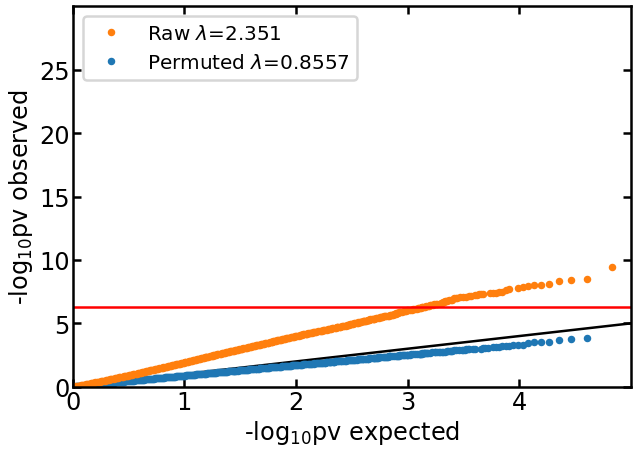

In [58]:
no_correction = pickle.load(open(corr_dir + 'raw_regress_confounders.pickle', 'rb'))
labels = ['Raw', 'Permuted']
pv = []
label = []
for i in [1,2]:
    flat_pvalues = no_correction[i].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    flat_pvalues = flat_pvalues[::2]
    lamb = estimate_lambda(flat_pvalues)
    pv.extend(flat_pvalues)
    label.extend(['{} $\lambda$={:0.4}'.format(labels[i-1], lamb)] * len(flat_pvalues))
    

df = pd.DataFrame(data=dict(pv=pv, label=label))

limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,5],[0,30]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=20, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')
plt.show()

In [ ]:
regress_peer

/homes/willj/miniconda3/envs/GTEx/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


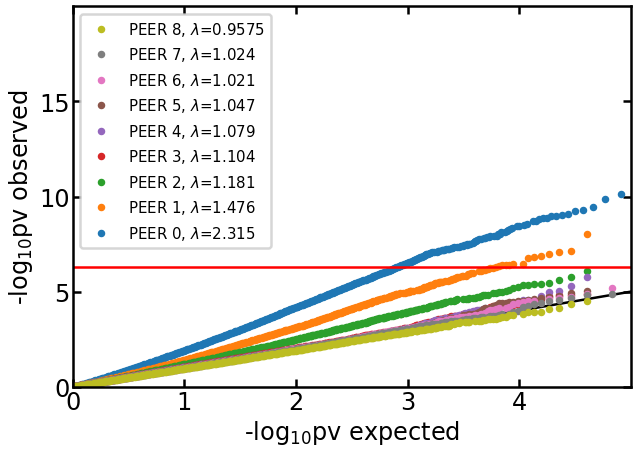

In [56]:
plt.figure(1, figsize=(15,10))
regress_cov = pickle.load(open(corr_dir + 'raw_regress_confounders.pickle', 'rb'))
regress_peer = pickle.load(open(corr_dir + 'raw_correct_confounders_regress_peer.pickle', 'rb'))
regress_peer = [regress_cov] + regress_peer
n_PEERs = [0,5,10,15,20,25,30,35,40]

pv = []
label = []
lambdas = [1.803, 1.476, 1.181, 1.104, 1.079, 1.047, 1.024, 1.021, 0.9575]
for (i, res) in enumerate([regress_peer[k] for k in n_PEERs]):
    flat_pvalues = res[1].flatten()
    flat_pvalues = flat_pvalues[flat_pvalues < 1]
    lamb = estimate_lambda(flat_pvalues)
    pv.extend(flat_pvalues)
    label.extend(['PEER {}, $\lambda$={:0.4}'.format(i,lamb)] * len(flat_pvalues))
    
df = pd.DataFrame(data=dict(pv=pv, label=label))

limix.plot.qqplot(df,cutoff=0.000001, limits=[[0,5],[0,20]], conf_interval=False)
limix.plot.figure.set_figheight(7)
limix.plot.figure.set_figwidth(10)
limix.plot.axes.set_yticks(limix.plot.axes.get_yticks()[::5])
handles, labels = limix.plot.axes.get_legend_handles_labels()
limix.plot.axes.legend(handles[::-1], labels[::-1], fontsize=15, loc='upper left')
bonf_threshold = -np.log10(0.05/len(flat_pvalues))
plt.plot([0,6.1], [bonf_threshold, bonf_threshold], c='red')
plt.show()

### Set of confounder independent PEER factors with permutations

In [6]:
confounders = pd.concat([donor_confounders.loc[RNA_sample_donors], sample_confounders.loc[RNA_sample_donors], RNA_sample_covariates],axis=1)

In [101]:
PEER_factors.loc[RNA_sample_donors]

(248, 60)

In [217]:
lr.score(f_confounders, f_PEER)

-0.35883893340333112

In [220]:
f_PEER.shape

(248, 60)

In [271]:
lr1 = LinearRegression()
f_PEER_perm = np.random.permutation(f_PEER)
lr1.fit(f_confounders, f_PEER_perm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [272]:
y_true = f_PEER_perm
y_pred = lr1.predict(f_confounders)
u = ((y_true - y_pred) ** 2).sum() 
v = ((y_true - y_true.mean()) ** 2).sum()

In [273]:
1 - (v/u)

0.057905095703240095

In [212]:
lr = LinearRegression()
f_confounders = confounders.loc[RNA_sample_donors].as_matrix()
f_PEER = PEER_factors.loc[RNA_sample_donors].as_matrix()
lr.fit(f_confounders, f_PEER)
true_variance_explained = 1 - np.var(f_PEER - lr.predict(f_confounders), axis=0)

In [ ]:
n = 10000
permuted_variance_explained = []
for i in range(n):
    if i % 1000 == 0:
        print (i)
    lr = LinearRegression()
    f_confounders = confounders.loc[RNA_sample_donors].as_matrix()
    f_PEER = PEER_factors.loc[RNA_sample_donors].as_matrix()
    lr.fit(f_confounders, np.random.permutation(f_PEER))
    variances = 1 - np.var(f_PEER - lr.predict(f_confounders), axis=0)
    permuted_variance_explained.append(variances)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [328]:
np.sum(np.array(permuted_variance_explained) > true_variance_explained, axis=0) / n

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.00000000e-04,   0.00000000e+00,   2.22400000e-01,
         0.00000000e+00,   0.00000000e+00,   7.55300000e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   3.09800000e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.87000000e-02,   1.97600000e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.47800000e-01,   0.00000000e+00,   7.63500000e-01,
         6.20000000e-03,   0.00000000e+00,   0.00000000e+00,
         7.00000000e-04,   0.00000000e+00,   4.62900000e-01,
         0.00000000e+00,

### Set of independent PEER factors to confounders - those that have no significant associations

 32%|███▏      | 850/2640 [00:00<00:00, 8495.96it/s]

Shuffle: real


 31%|███▏      | 828/2640 [00:00<00:00, 8277.98it/s]

Shuffle: shuffle


100%|██████████| 2640/2640 [00:00<00:00, 8235.10it/s]


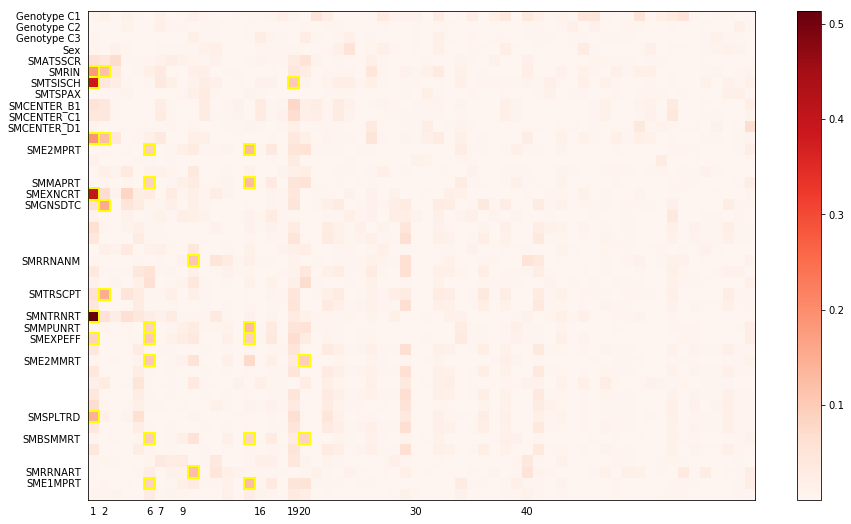

In [80]:
results = compute_pearsonR(confounders.as_matrix(), PEER_factors.loc[RNA_sample_donors].as_matrix())
confounders = pd.concat([donor_confounders.loc[RNA_sample_donors], sample_confounders.loc[RNA_sample_donors], RNA_sample_covariates],axis=1)
from matplotlib.patches import Rectangle
plt.figure(figsize=(15,9))
plt.imshow(results[0]**2, cmap='Reds')
ax = plt.subplot(111)
plt.colorbar()

#RNA 


#RNA expression confounders
y_locs = [1,4,5,6,11,14,16,17,18,20,25,27,30,31]
donor_and_sample_confounders = ['Genotype C1', 'Genotype C2', 'Genotype C3', 'Sex', 'SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1']
plt.yticks(list(range(11)) + [x + 11 for x in y_locs], donor_and_sample_confounders + [RNA_sample_covariates.columns[i] for i in y_locs], size=10)

# ['Genotype C1', 'Genotype C2', 'Genotype C3', 'Sex', 'SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1']
# plt.yticks(range(7), ['SMATSSCR', 'SMRIN', 'SMTSISCH', 'SMTSPAX', 'SMCENTER_B1','SMCENTER_C1', 'SMCENTER_D1'], size=15)
plt.xticks([0,1, 5, 6, 8, 15, 18, 19, 29,39], [1,2, 6, 7, 9, 16, 19,20,30,40], size=10)
plt.tick_params(axis='both', which='both', bottom='off', top='off', right='off', left='off')

bonf_threshold = 0.01 / len(results[1].T.flatten())
for loc in np.argwhere(results[1].T < bonf_threshold):
    ax.add_patch(Rectangle((-0.5 + loc[0],-0.5 + loc[1]), 1, 1, fill=False, edgecolor='yellow', lw=2))